In [ ]:
import os
import logging
import time
import psycopg2

import pandas as pd
import numpy as np

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def connect_postgres():
    database = os.environ['POSTGRES_DB']
    user = os.environ['POSTGRES_USER']
    password = os.environ['POSTGRES_PASSWORD']
    host = os.environ['POSTGRES_SERVER']
    port = 5432

    exc, conn = None, None

    for _ in range(5):
        try:
            conn = psycopg2.connect(
                database=database, user=user, password=password, host=host, port=port)
        except Exception as e:
            logging.warning("Error connecting to postgres, will retry in 3 sec: %s", e)
            time.sleep(3)
            exc = e
        else:
            logging.info("Connected...")
            logging.info("Everything goes well from Postgres, you're a fu*** pro...")
            break
    else:
        logging.error("Unable to connect to  %s DB", database)
        raise exc
    
    return conn


In [ ]:
engine = connect_postgres()

In [ ]:
df = pd.read_sql("""
    SELECT code, estrato, birth_date,
    DATE_PART('year', to_date(SUBSTRING(code::text, 1, 4)::text, 'YYYY')) - DATE_PART('year', student.birth_date::date) as age,
    sexo, m_grado, m_activo, m_tesis, per_cancelados, per_matriculados, bajos_rendimientos, trans_type_code, count(trans_type_code)
    FROM public.copytransaction, public.student, public.transactiontype, public.date
    WHERE trans_borrower_code = student.id
        AND trans_type_id = transactiontype.id
        AND trans_location_code_id = 5
        AND trans_type_code = 'ISS'
        AND trans_date_id = date.id
    GROUP BY code, estrato, birth_date, sexo, m_grado, m_activo, m_tesis, per_cancelados, age, per_matriculados, bajos_rendimientos, trans_type_code    
""", con=engine)

In [ ]:
df

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56412 entries, 0 to 56411
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   code                56412 non-null  int64  
 1   estrato             56412 non-null  int64  
 2   birth_date          56412 non-null  object 
 3   age                 56412 non-null  float64
 4   sexo                56412 non-null  object 
 5   m_grado             56412 non-null  bool   
 6   m_activo            56412 non-null  bool   
 7   m_tesis             56412 non-null  bool   
 8   per_cancelados      56412 non-null  int64  
 9   per_matriculados    56412 non-null  int64  
 10  bajos_rendimientos  56412 non-null  bool   
 11  trans_type_code     56412 non-null  object 
 12  count               56412 non-null  int64  
dtypes: bool(4), float64(1), int64(5), object(3)
memory usage: 4.1+ MB


In [8]:
df["bajos_rendimientos"] = df["bajos_rendimientos"].astype(int)
df["m_grado"] = df["m_grado"].astype(int)
df["m_activo"] = df["m_activo"].astype(int)
df["m_tesis"] = df["m_tesis"].astype(int)
df["age"] = df["age"].astype(int)

# df = df.drop(columns=['trans_type_code'])

In [9]:
#exploring the data

# checking null values
df.isnull().sum()

# visualize them
# df[df['bajos_rendimientos'].isnull()]

code                  0
estrato               0
birth_date            0
age                   0
sexo                  0
m_grado               0
m_activo              0
m_tesis               0
per_cancelados        0
per_matriculados      0
bajos_rendimientos    0
trans_type_code       0
count                 0
dtype: int64

In [10]:
df.drop(df[df['age'] < 14].index, inplace = True)
df.drop(df[df['age'] > 80].index, inplace = True)

In [11]:
# investigate all the elements within each feature

for column in df:
    unique_values = np.unique(df[column])
    nr_values = len(unique_values)
    if nr_values < 100:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_values))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature code :56290
The number of values for feature estrato :8 -- [ 0  1  2  3  4  5  6 11]
The number of values for feature birth_date :11647
The number of values for feature age :54 -- [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63 64 67 69 73]
The number of values for feature sexo :2 -- ['F' 'M']
The number of values for feature m_grado :2 -- [0 1]
The number of values for feature m_activo :2 -- [0 1]
The number of values for feature m_tesis :2 -- [0 1]
The number of values for feature per_cancelados :9 -- [0 1 2 3 4 5 6 7 8]
The number of values for feature per_matriculados :37 -- [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 45]
The number of values for feature bajos_rendimientos :2 -- [0 1]
The number of values for feature trans_type_code :1 -- ['ISS']
The number of values for feature co

In [12]:
df.describe()

,code,estrato,age,m_grado,m_activo,m_tesis,per_cancelados,per_matriculados,bajos_rendimientos,count
count,5.629000e+04,56290.000000,56290.000000,56290.000000,56290.000000,56290.000000,56290.000000,56290.000000,56290.000000,56290.000000
mean,2.006879e+08,2.199147,20.033665,0.463386,0.215012,0.001013,0.176195,8.974596,0.138213,51.897673
std,6.872306e+05,0.831049,4.243644,0.498662,0.410834,0.031806,0.477505,5.082117,0.345126,83.283829
min,1.982246e+08,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.002257e+08,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,5.000000
50%,2.007355e+08,2.000000,19.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,20.000000
75%,2.012414e+08,3.000000,21.000000,1.000000,0.000000,0.000000,0.000000,13.000000,0.000000,64.000000
max,2.018800e+08,11.000000,73.000000,1.000000,1.000000,1.000000,8.000000,45.000000,1.000000,2188.000000


In [25]:
# Getting the columns we need

df.columns

Index(['code', 'estrato', 'birth_date', 'age', 'sexo', 'm_grado', 'm_activo',
       'm_tesis', 'per_cancelados', 'per_matriculados', 'bajos_rendimientos',
       'trans_type_code', 'count', 'Clusters'],
      dtype='object')

In [ ]:
features = ['code', 'estrato', 'birth_date', 'age', 'sexo', 'm_grado', 'm_activo',
       'm_tesis', 'per_cancelados', 'per_matriculados', 'bajos_rendimientos',
       'trans_type_code', 'count']

for f in features:
    sns.countplot(x = f, data = df, palette = 'Set3')# hue = 'Good Loan')
    plt.xticks(rotation=45)
    plt.show()
    

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

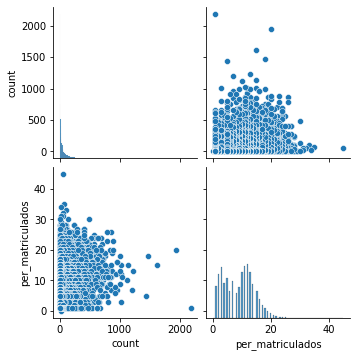

In [15]:
# Plot age, estrato, per_cancelados, per_matriculados
sns.pairplot(df[['count', 'per_matriculados']])

In [16]:
import sklearn.cluster as cluster

kmeans = cluster.KMeans(n_clusters=5, init='k-means++', random_state=540)
kmeans = kmeans.fit(df[['per_matriculados', 'count']])

In [17]:
kmeans.cluster_centers_

array([[  7.9233664 ,  13.22937446],
       [ 11.59498736, 177.07413648],
       [ 12.29542302, 339.70319001],
       [ 10.80686804,  77.58353021],
       [ 12.98795181, 676.69477912]])

In [18]:
df['Clusters'] = kmeans.labels_

In [19]:
df.head()

,code,estrato,birth_date,age,sexo,m_grado,m_activo,m_tesis,per_cancelados,per_matriculados,bajos_rendimientos,trans_type_code,count,Clusters
0,198224610,2,1957-01-01,25,M,0,1,0,0,10,0,ISS,30,0
1,199000484,2,1970-01-01,20,F,1,0,0,0,12,0,ISS,31,0
2,199000896,2,1947-01-01,43,M,0,0,0,3,28,0,ISS,227,1
3,199001027,2,1971-06-25,19,F,1,0,0,0,17,0,ISS,34,0
4,199001038,2,1969-02-03,21,F,1,0,0,1,20,0,ISS,3,0


In [20]:
df['Clusters'].value_counts()

0    37999
3    11852
1     4748
2     1442
4      249
Name: Clusters, dtype: int64

<AxesSubplot:xlabel='per_matriculados', ylabel='count'>

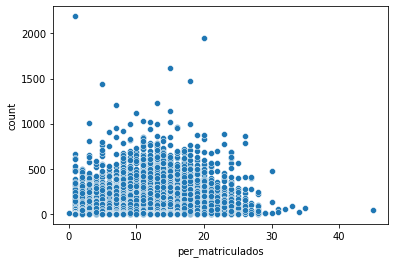

In [21]:
# Plot clusters on charts
sns.scatterplot(x='per_matriculados', y='count', data=df)